In [29]:
# main imports
import os
import sys
import ast
import copy
import glob
import math
import shutil
import random
import importlib
import subprocess

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pylab as pylab
import upsetplot
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz4-4/avaraby/orfanage/soft")
%aimport definitions

In [8]:
# paths

base_dir = "/ccb/salz4-4/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"
gmst_bin = base_dir+"soft/gmst/gmst.pl"

fa_fname = base_dir+"data/hg38.fa"
gtf_fname = base_dir+"data/gencode.v41.gtf"
mane_gtf_fname = base_dir+"data/MANE.v10.gtf"

outdir = base_dir+"gmst_gencode_rev1/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [4]:
# arguments
num_threads = 30

In [64]:
gtf_adjstop_fname = gtf_fname.rsplit(".",1)[0]+".adjstop.gtf"
gtf_adjstop_sorted_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".sorted.gtf"
gtf_adjstop_aa_fa_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".aa.fa"

clean_gtf_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".clean.gtf"
nocds_gtf_fname = clean_gtf_fname.rsplit(".",1)[0]+".nocds.gtf"
nocds_gff_fname = nocds_gtf_fname.rsplit(".",1)[0]+".gff3"
nocds_fa_fname = nocds_gtf_fname.rsplit(".",1)[0]+".fa"

out_gtf_fname = outdir+"orf.gtf"
out_stats_fname = outdir+"orf.stats"
out_gtf_sorted_fname = outdir.rsplit(".",1)[0]+".sorted.gtf"

out_df_tsv_fname = outdir+"df.tsv"

In [7]:
%%time
# run orfanage with mane as the reference
cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",nocds_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtf_fname,
       "--stats",out_stats_fname,
       mane_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz4-4/avaraby/orfanage/bin/orfanage --reference /ccb/salz4-4/avaraby/orfanage/data/hg38.fa --query /ccb/salz4-4/avaraby/orfanage/data/gencode.v41.adjstop.clean.nocds.gtf --threads 30 --output /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.gtf --stats /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.stats /ccb/salz4-4/avaraby/orfanage/data/MANE.v10.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


CPU times: user 3.79 ms, sys: 10.3 ms, total: 14.1 ms
Wall time: 17.5 s


0

In [63]:
cmd = [gffread_bin,"-T","-o",out_gtf_fname.split(".gtf")[0]+".gffread.gtf",out_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)
igv_cmd = [igvtools_bin,"sort",out_gtf_fname.split(".gtf")[0]+".gffread.gtf",out_gtf_fname.split(".gtf")[0]+".sorted.gtf"]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",out_gtf_fname.split(".gtf")[0]+".sorted.gtf"]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

/ccb/salz7-data/sw2/bin/gffread -T -o /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.gffread.gtf /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.gtf
/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.gffread.gtf /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.sorted.gtf
Sorting /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.gffread.gtf  -> /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.sorted.gtf


Snappy is disabled via system property.


Done
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/orf.sorted.gtf
Done


0

In [9]:
# extract nt fasta with gffread
cmd = [gffread_bin,
       "-g",fa_fname,
       "-w",outdir+"tx.nt.fasta",
       nocds_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz7-data/sw2/bin/gffread -g /ccb/salz4-4/avaraby/orfanage/data/hg38.fa -w /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/tx.nt.fasta /ccb/salz4-4/avaraby/orfanage/data/gencode.v41.adjstop.clean.nocds.gtf


0

In [12]:
%%time
cmd = [gmst_bin,"--strand","direct",
                "--output",outdir+"gmst.res",
                "--format","GFF",
                outdir+"tx.nt.fasta"]
print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz4-4/avaraby/orfanage/soft/gmst/gmst.pl --strand direct --output /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.res --format GFF /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/tx.nt.fasta
CPU times: user 133 ms, sys: 64.5 ms, total: 198 ms
Wall time: 1h 39min 29s


0

In [16]:
chains = definitions.get_chains(nocds_gtf_fname,"exon",True)
chains.head()

,tid,has_cds,seqid,strand,coords,chain
0,ENST00000456328.2,1,chr1,+,chr1:11869-14409,"[[11869, 12227], [12613, 12721], [13221, 14409]]"
1,ENST00000450305.2,1,chr1,+,chr1:12010-13670,"[[12010, 12057], [12179, 12227], [12613, 12697..."
2,ENST00000488147.1,1,chr1,-,chr1:14404-29570,"[[14404, 14501], [15005, 15038], [15796, 15947..."
3,ENST00000619216.1,1,chr1,-,chr1:17369-17436,"[[17369, 17436]]"
4,ENST00000473358.1,1,chr1,+,chr1:29554-31097,"[[29554, 30039], [30564, 30667], [30976, 31097]]"


In [39]:
# need to convert to genomic coordinates now

orfs = dict()

count = 0
with open("/ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.res","r") as inFP:
    for line in inFP:
        if line[0]=="#":
            continue
        if len(line.strip())==0:
            continue
        
        lcs = line.strip().split("\t")
        if not lcs[2]=="CDS":
            print(lcs[2])
            
        tstart = int(lcs[3])-1
        tend = int(lcs[4])-1
        tid = lcs[0]
        
        chain = chains[chains["tid"]==tid].iloc[0].chain
        strand = chains[chains["tid"]==tid].iloc[0].strand
        
        gstart = definitions.trans2genome(chain,strand,tstart)
        gend = definitions.trans2genome(chain,strand,tend)
        
        orf = definitions.cut_chain(chain,min(gstart,gend),max(gstart,gend))
        orfs.setdefault(tid,list())
        orfs[tid].append(orf)
        
        
        count+=1
        if count%10000==0:
            print(count)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000


In [40]:
# now we just need ot output results into a GTF
multi_orfs = set()
with open(outdir+"gmst.clean.genome.gtf","w+") as outFP:
    with open(nocds_gtf_fname,"r") as inFP:
        for line in inFP:
                
            lcs = line.strip().split('\t')
            tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
            # if not tid in orfs:
            #     continue
            
            if lcs[2] in ["transcript","exon"]:
                outFP.write(line)
            
            if lcs[2] == "transcript":
                if not tid in orfs:
                    continue
                if len(orfs[tid])>1:
                    print("multiple orfs: "+tid)
                    multi_orfs.add(tid)
                    continue
                    
                cds_lcs = copy.deepcopy(lcs)
                cds_lcs[2] = "CDS"
                cds_lcs[8] = "transcript_id \""+tid+"\";"
                
                for orf in orfs[tid]:
                    for cs,ce in orf:
                        cds_lcs[3] = str(int(cs))
                        cds_lcs[4] = str(int(ce))
                        outFP.write("\t".join(cds_lcs)+"\n")

multiple orfs: ENST00000462591.1
multiple orfs: ENST00000648727.1
multiple orfs: ENST00000462501.1
multiple orfs: ENST00000422468.1
multiple orfs: ENST00000612675.4
multiple orfs: ENST00000429315.3
multiple orfs: ENST00000692727.1
multiple orfs: ENST00000494569.5
multiple orfs: ENST00000626979.2
multiple orfs: ENST00000510778.7
multiple orfs: ENST00000496241.6
multiple orfs: ENST00000606961.1
multiple orfs: ENST00000525674.5
multiple orfs: ENST00000480327.2
multiple orfs: ENST00000696774.1
multiple orfs: ENST00000690052.1
multiple orfs: ENST00000395900.1
multiple orfs: ENST00000672270.1
multiple orfs: ENST00000680351.1
multiple orfs: ENST00000680010.1
multiple orfs: ENST00000696934.1
multiple orfs: ENST00000482172.5
multiple orfs: ENST00000522618.1
multiple orfs: ENST00000572950.1
multiple orfs: ENST00000580840.1
multiple orfs: ENST00000577760.1
multiple orfs: ENST00000585457.6
multiple orfs: ENST00000597007.5
multiple orfs: ENST00000655331.1
multiple orfs: ENST00000660190.2
multiple o

In [89]:
cmd = [gffread_bin,"-T","-g",fa_fname,"-o",outdir+"gmst.gffread.gtf",outdir+"gmst.clean.genome.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
igv_cmd = [igvtools_bin,"sort",outdir+"gmst.gffread.gtf",outdir+"gmst.sorted.gtf"]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",outdir+"gmst.sorted.gtf"]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

/ccb/salz7-data/sw2/bin/gffread -T -g /ccb/salz4-4/avaraby/orfanage/data/hg38.fa -o /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.gffread.gtf /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.clean.genome.gtf
/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.gffread.gtf /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.sorted.gtf
Sorting /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.gffread.gtf  -> /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.sorted.gtf


Snappy is disabled via system property.


Done
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz4-4/avaraby/orfanage/gmst_gencode_rev1/gmst.sorted.gtf
Done


0

209884
total number of transcripts: 128154
all equal: 52085
ORFanage==GENCODE!=GeneMarkS-T: 31610
Of those, these many are coding in GeneMarkS-T: 28086
Of those, these many are coding in both GENCODE and ORFanage: 23100
Of those, these many are non-coding in both GENCODE and ORFanage: 8510
ORFanage!=GENCODE==GeneMarkS-T: 11026
Of those, these many are coding in both GENCODE and GeneMarkS-T: 1199
Of those, these many are non-coding in both GENCODE and GeneMarkS-T: 9827
All different: 15818


<Axes: >

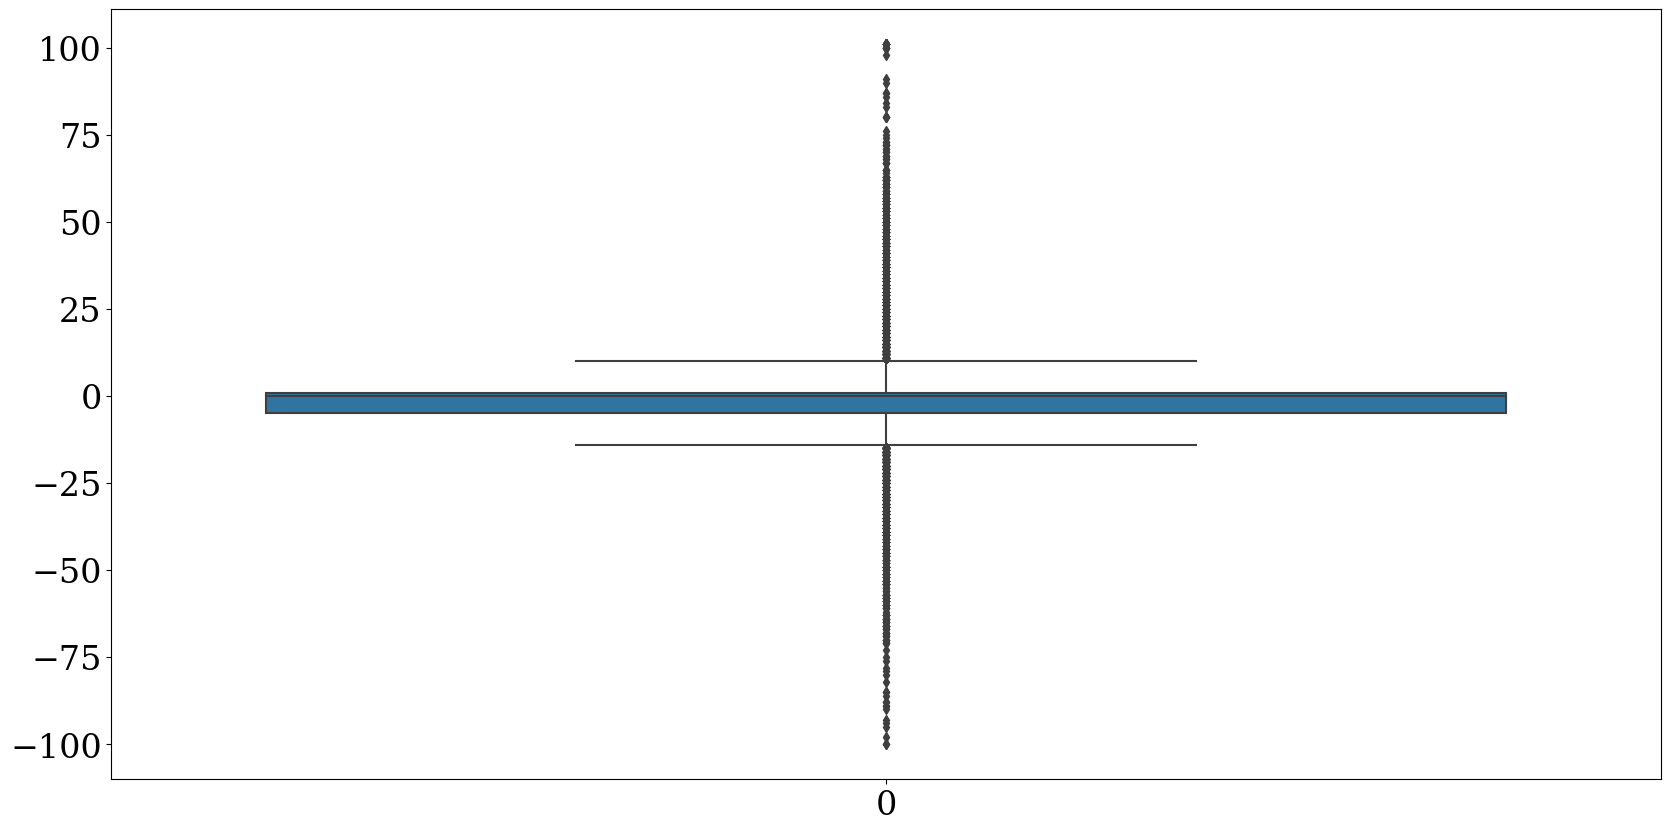

In [90]:
# load chains
gmst_df = definitions.get_chains(outdir+"gmst.sorted.gtf","CDS",True)
# extract length from the chain
gmst_df["clen"] = gmst_df.apply(lambda row: definitions.clen(row["chain"]),axis=1)
# sort and remove duplicates keeping only the longest ORF
gmst_df.sort_values(by=["tid","clen"],ascending=False,inplace=True)
print(len(gmst_df))

# remove junk and rename
gmst_df = gmst_df[["tid","has_cds","chain"]]
gmst_df.columns = ["tid","gmst_has_cds","gmst_chain"]


# load original chains
def_df = definitions.get_chains(clean_gtf_fname,"CDS",True)
# add gene ids
def_attr = definitions.get_attribute(clean_gtf_fname,"gene_id")
def_attr.columns = ["tid","gid"]
def_df = def_df.merge(def_attr,on="tid",how="left")
def_df = def_df[["tid","gid","has_cds","chain"]]
def_df.columns = ["tid","gid","def_has_cds","def_chain"]


# load orfanage results
orf_df = definitions.get_chains(out_gtf_fname,"CDS",True)
orf_df = orf_df[["tid","has_cds","chain"]]
orf_df.columns = ["tid","orf_has_cds","orf_chain"]


# load mane
mane_df = definitions.get_chains(mane_gtf_fname,"CDS",True)
# add gene ids
mane_attr = definitions.get_attribute(mane_gtf_fname,"gene_id")
mane_attr.columns = ["tid","gid"]
mane_df = mane_df.merge(def_attr,on="tid",how="left")
mane_df = mane_df[["tid","gid","chain","strand","coords"]]
mane_df.columns = ["mane_tid","gid","mane_chain","strand","coords"]


# merge all dataframes into one
df = def_df.merge(mane_df,on="gid",how="left")
df = df[df["gid"].isin(set(mane_df["gid"]))].reset_index(drop=True)
df = df.merge(gmst_df,on="tid",how="left")
df = df.merge(orf_df,on="tid",how="left")
df["gmst_has_cds"] = df["gmst_has_cds"].fillna(0)
df["gmst_chain"] = df.apply(lambda row: list() if row["gmst_chain"]!=row["gmst_chain"] else row["gmst_chain"],axis=1)

# no_cds_df = df[df["def_has_cds"]==1].reset_index(drop=True)
# df = df[df["def_has_cds"]==1].reset_index(drop=True)

all_same = df[(df["gmst_chain"]==df["orf_chain"])&\
              (df["orf_chain"]==df["def_chain"])].reset_index(drop=True)

orf_eq_def_ne_gmst = df[~(df["gmst_chain"]==df["orf_chain"])&\
                       (df["orf_chain"]==df["def_chain"])].reset_index(drop=True)

gmst_eq_def_ne_orf = df[~(df["gmst_chain"]==df["orf_chain"])&\
                       (df["gmst_chain"]==df["def_chain"])].reset_index(drop=True)

ad = df[~(df["gmst_chain"]==df["orf_chain"])&\
              ~(df["gmst_chain"]==df["def_chain"])&\
              ~(df["orf_chain"]==df["def_chain"])].reset_index(drop=True)

print("total number of transcripts: "+str(len(df)))
print("all equal: "+str(len(all_same)))
print("ORFanage==GENCODE!=GeneMarkS-T: "+str(len(orf_eq_def_ne_gmst)))
print("Of those, these many are coding in GeneMarkS-T: "+str(len(orf_eq_def_ne_gmst[orf_eq_def_ne_gmst["gmst_has_cds"]==1])))
print("Of those, these many are coding in both GENCODE and ORFanage: "+str(len(orf_eq_def_ne_gmst[orf_eq_def_ne_gmst["orf_has_cds"]==1])))
print("Of those, these many are non-coding in both GENCODE and ORFanage: "+str(len(orf_eq_def_ne_gmst[orf_eq_def_ne_gmst["orf_has_cds"]==0])))
print("ORFanage!=GENCODE==GeneMarkS-T: "+str(len(gmst_eq_def_ne_orf)))
print("Of those, these many are coding in both GENCODE and GeneMarkS-T: "+str(len(gmst_eq_def_ne_orf[gmst_eq_def_ne_orf["gmst_has_cds"]==1])))
print("Of those, these many are non-coding in both GENCODE and GeneMarkS-T: "+str(len(gmst_eq_def_ne_orf[gmst_eq_def_ne_orf["gmst_has_cds"]==0])))

print("All different: "+str(len(ad)))

# compare mane ILPD
ad[["mod_chain_orf",
         "c1len_orf",
         "c2len_orf",
         "match_start_orf",
         "match_end_orf",
         "num_bp_extra_orf",
         "num_bp_missing_orf",
         "num_bp_inframe_orf",
         "num_bp_match_orf",
         "num_bp_outframe_orf",
         "lpd_orf",
         "ilpd_orf",
         "mlpd_orf"]] = ad.apply(lambda row: definitions.compare_and_extract(row["orf_chain"],row["mane_chain"],row["strand"]),axis=1)
ad.drop(["mod_chain_orf",
         "c1len_orf",
         "c2len_orf",
         "match_start_orf",
         "match_end_orf",
         "num_bp_extra_orf",
         "num_bp_missing_orf",
         "num_bp_inframe_orf",
         "num_bp_match_orf",
         "num_bp_outframe_orf",
         "lpd_orf",
         "mlpd_orf"],axis=1,inplace=True)

ad[["mod_chain_gmst",
         "c1len_gmst",
         "c2len_gmst",
         "match_start_gmst",
         "match_end_gmst",
         "num_bp_extra_gmst",
         "num_bp_missing_gmst",
         "num_bp_inframe_gmst",
         "num_bp_match_gmst",
         "num_bp_outframe_gmst",
         "lpd_gmst",
         "ilpd_gmst",
         "mlpd_gmst"]] = ad.apply(lambda row: definitions.compare_and_extract(row["gmst_chain"],row["mane_chain"],row["strand"]),axis=1)
ad.drop(["mod_chain_gmst",
         "c1len_gmst",
         "c2len_gmst",
         "match_start_gmst",
         "match_end_gmst",
         "num_bp_extra_gmst",
         "num_bp_missing_gmst",
         "num_bp_inframe_gmst",
         "num_bp_match_gmst",
         "num_bp_outframe_gmst",
         "lpd_gmst",
         "mlpd_gmst"],axis=1,inplace=True)

ad["ilpd_diff"] = ad["ilpd_orf"]-ad["ilpd_gmst"]
sns.boxplot(ad["ilpd_diff"])

In [94]:
len(df[(df["def_has_cds"]==0)&(df["gmst_has_cds"]==1)]),len(df[(df["def_has_cds"]==0)&(df["orf_has_cds"]==1)])

(34169, 35486)

In [99]:
orf_tp_df = (df[(df["def_has_cds"]==1)&(df["orf_chain"]==df["def_chain"])])
orf_fp_df = (df[(df["def_has_cds"]==0)&(df["orf_has_cds"]==1)])
orf_tn_df = (df[(df["def_has_cds"]==0)&(df["orf_chain"]==df["def_chain"])])
orf_fn_df = (df[(df["def_has_cds"]==1)&~(df["orf_chain"]==df["def_chain"])])

print(len(orf_tp_df),len(orf_fp_df),len(orf_tn_df),len(orf_fn_df))
sens = len(orf_tp_df)/(len(orf_tp_df)+len(orf_fn_df))
print(sens)

gmst_tp_df = (df[(df["def_has_cds"]==1)&(df["gmst_chain"]==df["def_chain"])])
gmst_fp_df = (df[(df["def_has_cds"]==0)&(df["gmst_has_cds"]==1)])
gmst_tn_df = (df[(df["def_has_cds"]==0)&(df["gmst_chain"]==df["def_chain"])])
gmst_fn_df = (df[(df["def_has_cds"]==1)&~(df["gmst_chain"]==df["def_chain"])])

print(len(gmst_tp_df),len(gmst_fp_df),len(gmst_tn_df),len(gmst_fn_df))
sens = len(gmst_tp_df)/(len(gmst_tp_df)+len(gmst_fn_df))
print(sens)

63936 35486 19759 8973
0.8769287742254043
42035 34169 21076 30874
0.5765406191279541


In [100]:
orf_tpr = len(orf_tp_df)/(len(orf_tp_df)+len(orf_fn_df))
print("TPR ORFanage: "+str(orf_tpr))
orf_tpr = len(orf_tn_df)/(len(orf_tn_df)+len(orf_fp_df))
print("FNR ORFanage: "+str(orf_tpr))

gmst_tpr = len(gmst_tp_df)/(len(gmst_tp_df)+len(gmst_fn_df))
print("TPR GeneMarkS-T: "+str(gmst_tpr))
gmst_tpr = len(gmst_tn_df)/(len(gmst_tn_df)+len(gmst_fp_df))
print("FNR GeneMarkS-T: "+str(gmst_tpr))

TPR ORFanage: 0.8769287742254043
FNR ORFanage: 0.3576613268169065
TPR GeneMarkS-T: 0.5765406191279541
FNR GeneMarkS-T: 0.3815005882885329


In [78]:
sad = ad[(ad["gmst_has_cds"]==1)&(ad["orf_has_cds"]==1)].reset_index(drop=True)
print(len(sad[sad["ilpd_diff"]>0])/len(sad))
print(len(sad[sad["ilpd_diff"]==0])/len(sad))

0.711864406779661
0.288135593220339


<Axes: >

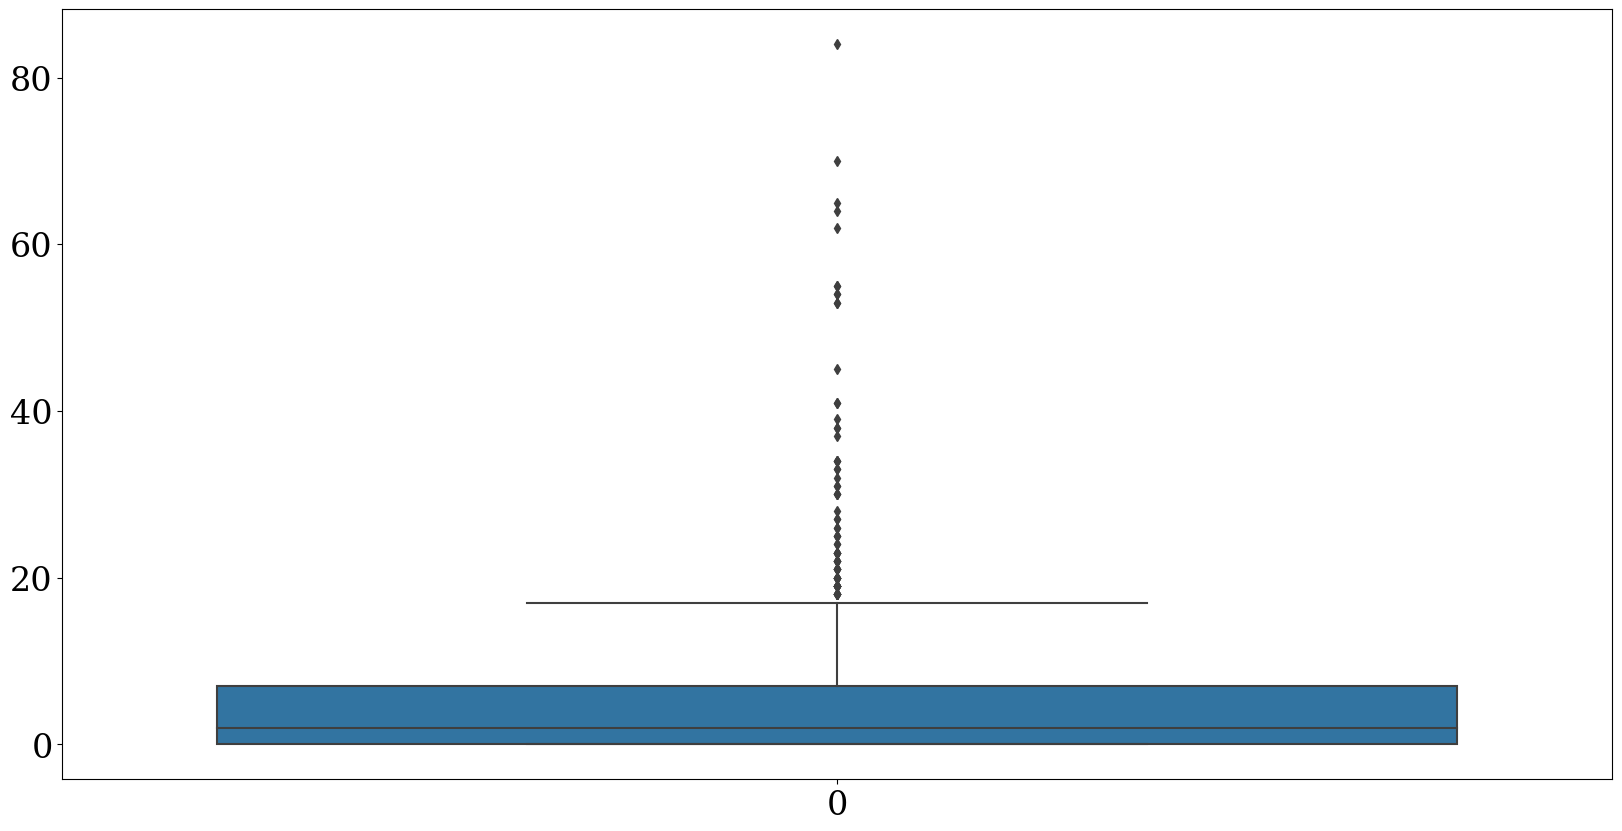

In [79]:
sns.boxplot(sad["ilpd_diff"])